In [1]:
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, add
from tensorflow.keras import regularizers

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import datetime
import glob
import time
from sklearn.model_selection import train_test_split

**replace `RACECAR_IP`** with the address to your car and copy the folder collected using `record_RACECAR.py` to the environment you are using for training:

```
scp -r racecar@RACECAR_IP:~/imitation_learning_lab/run_DATE ./data_and_models/collects/
```

In [3]:
# CSV from record_RACECAR.py

driving_data = "../data_and_models/collects/run_04_12_17_26/run_04_12_17_26.csv"
parent_dir = os.path.dirname(driving_data) + os.path.sep

print(len(os.listdir(parent_dir)), " files found")

22620  files found


This notebook will train an implementation of Nvidia's PilotNet using TensorFlow/Keras. As an exercise you should modify some or all of the following and compare against the baseline implementation here.

* Drop out probability
* Number of epochs  
* Samples per epoch  
* Batch size         
* Learning rate
* Model layers, outputs: e.g., add regularization, or speed prediction
* Image size (cropped or scaled)
* Image augmentation


Some comparison metrics:

* Can you drive faster than the baseline?
* Do you require less data to train? More?
* Model generalization:
    * Can your model be used on a different car? 
    * Can you slightly change the angle of the front camera at inference time?
    * Does the presence of people or lighting variations affect your model's performance?

In [4]:
imgs   = []
ngls   = []
speeds = []
lines  = 0
with open(driving_data) as fh:
    for line in fh:
        lines = lines + 1
        l = line.split(',')
        
        speed = l[2]
        speed = float(speed)
        
        # filter out data when the car is stopped
        #if np.isclose(speed, 0.):
        if speed < 0.5:
            continue
        
        speeds.append(speed)
        
        img = l[0]
        imgs.append(parent_dir + img)
       
        ngl = l[1]
        ngl = float(ngl)
        ngls.append(ngl)
print("total data", lines)
print("filtered data", len(imgs), len(ngls), len(speeds))

total data 22619
filtered data 21574 21574 21574


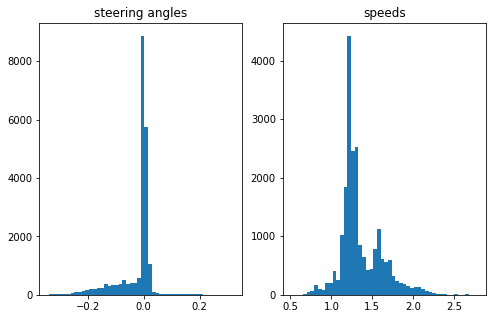

In [5]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(ngls, bins=50);
ax[1].hist(speeds, bins=50);
ax[0].set_title("steering angles")
ax[1].set_title("speeds")
fig.set_size_inches(8,5);

In [6]:
def split_lcr(image, width=320, height=240):
    left   = image[0:height, 0:width, :]
    center = image[0:height, width:(width*2), :]
    right  = image[0:height, (width*2):(width*3), :]
    return (left,center,right)

In [7]:
def pilotnet_crop(image):
    """assumes 320x240 input, resizes to 200x66"""
    # rows:    (240 - 66) / 2 == 87
    # columns: (320 - 200) /2 == 60 
    return image[87:-87, 60:-60] 

You can try a different size input

In [34]:
def pilotnet_crop_large(image):
    """assumes 320x240 input, resizes to 250x120"""
    # rows:    (240 - 120) / 2 == 60
    # columns: (320 - 250) /2 == 35
    return image[60:-60, 35:-35] 

You might want to grab more of the image area and shrink it down (instead of just cropping the center of the image out):

```python
cv.resize(image,(0,0), fx=0.4, fy=0.4, interpolation=cv.INTER_AREA )
```

In [8]:
def shrink(image):
    return cv.resize(image, (200,66), cv.INTER_AREA)

angle: -0.004


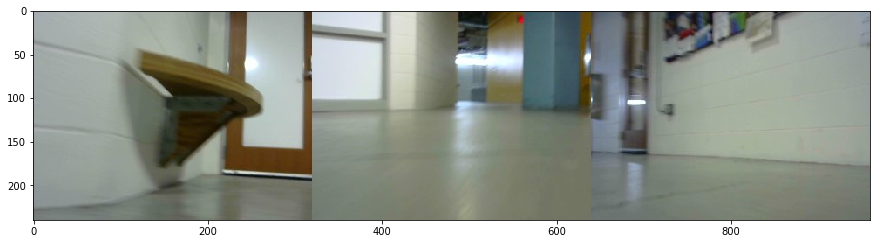

In [13]:
random_id = np.random.randint(0, len(imgs)-1)

img = cv.imread(imgs[random_id], cv.IMREAD_COLOR)

print("angle: {:02.3f}".format(ngls[random_id]))
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(rgb)
fig.set_size_inches(15,5);

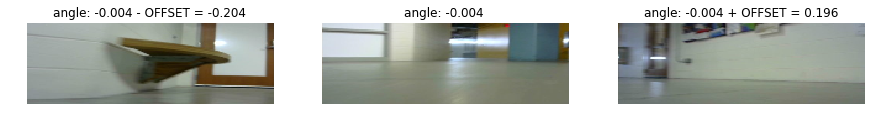

In [14]:
TRY_OFFSET = 0.2
USE_FULL_FRAME = True

fig, ax = plt.subplots(ncols=3)
l,c,r = split_lcr(rgb)

if USE_FULL_FRAME:
    l = shrink(l)
    c = shrink(c)
    r = shrink(r)
else:
    l = pilotnet_crop(l)
    c = pilotnet_crop(c)
    r = pilotnet_crop(r)

ax[0].imshow(l)
ax[1].imshow(c)
ax[2].imshow(r)

ngl = ngls[random_id]
ax[0].set_title("angle: {:02.3f} - OFFSET = {:02.3f}".format(ngl, ngl - TRY_OFFSET))
ax[1].set_title("angle: {:02.3f} ".format(ngl))
ax[2].set_title("angle: {:02.3f} + OFFSET = {:02.3f}".format(ngl, ngl + TRY_OFFSET))

for a in ax.flatten():
    a.axis('off')
fig.set_size_inches(15,5);

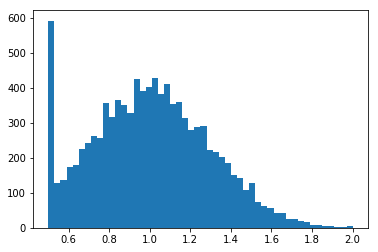

In [15]:
def increase_brightness(img):
    # perceptually a bit more uniform than perturb_gamma
    value = np.random.randint(20,60)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return img

def make_random_gamma():
    random_gamma = np.random.normal(1, 0.3)
    random_gamma = np.clip(random_gamma, 0.5, 2)
    return random_gamma

def perturb_gamma(img): # https://stackoverflow.com/a/51174313
    gamma = make_random_gamma()
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv.LUT(img, table.astype(np.uint8))

# visualize range of random gamma perturbations
rg = [make_random_gamma() for i in range(10000)]
plt.hist(rg, bins=50);

random gamma


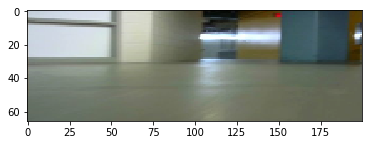

In [28]:
# augmentation
q = np.copy(c)
qbgr = cv.cvtColor(q, cv.COLOR_RGB2BGR)
if np.random.random() < 0.5:
    print("increasing brighness")
    qbgr = increase_brightness(qbgr)
else:
    print("random gamma")
    qbgr = perturb_gamma(qbgr)
q = cv.cvtColor(qbgr, cv.COLOR_BGR2RGB)
plt.imshow(q);

In [29]:
TEST_SIZE_FRACTION = 0.15
SEED = 56709 #awoo

X_train, X_valid, y_train, y_valid = train_test_split(
    imgs, 
    ngls, 
    test_size=TEST_SIZE_FRACTION, 
    shuffle=False
)
#,random_state=SEED)

print(len(X_train), len(X_valid))

18337 3237


In [30]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
#IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 120, 250, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


def build_model(dropout_rate=0.5):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE)) #normalize the data
    model.add(Conv2D(24, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary() # prints out the model description
    return model

In [31]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
__________

In [38]:
MODEL_NAME = "stata_{}_".format(datetime.datetime.now().strftime("%m_%d_%H_%M")) 

model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

checkpoint = ModelCheckpoint(MODEL_NAME + '{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=False,
                             mode='auto')

In [39]:
def augment(img):
    ################################
    ## TODO
    ## add more augmentations here
    #################################
    
    # augment half the time
    augment = np.random.rand()
    if augment < 0.5:
        do_gamma = np.random.rand()
        if do_gamma < 0.5:
            img = perturb_gamma(img)
        else:
            img = increase_brightness(img)
    return img

In [40]:
OFFSET_STEERING_ANGLE = 0.2 # NOTE: use two values if the left/right camera angles are not symmetric

def batch_generator(image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            
            lcr_image = cv.imread(image_paths[index])
            l,c,r = split_lcr(lcr_image)
            #l = pilotnet_crop(l)
            #c = pilotnet_crop(c)
            #r = pilotnet_crop(r)
            l = shrink(l)
            c = shrink(c)
            r = shrink(r)
            
            
            groundtruth_steering_angle = steering_angles[index]
            
            if is_training:
                dice = np.random.rand()
                # choose left
                if dice < 0.2:
                    images[i] = augment(l)
                    steers[i] = groundtruth_steering_angle - OFFSET_STEERING_ANGLE
                # choose center (60% of the time)
                elif dice < 0.8:
                    images[i] = augment(c)
                    steers[i] = groundtruth_steering_angle
                # choose right
                else:
                    images[i] = augment(r)
                    steers[i] = groundtruth_steering_angle + OFFSET_STEERING_ANGLE
            
            else: #only validate with center images (why? no real reason)
                images[i] = c
                steers[i] = groundtruth_steering_angle
            
            i += 1
            if i == batch_size:
                break
        yield images, steers

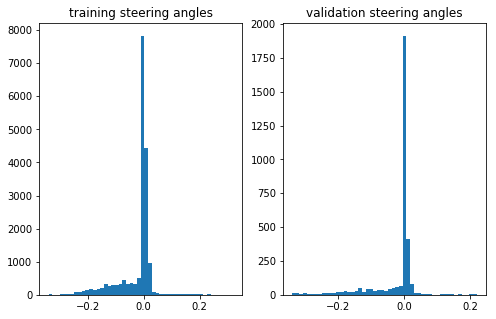

In [41]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(y_train, bins=50);
ax[0].set_title("training steering angles")
ax[1].hist(y_valid, bins=50);
ax[1].set_title("validation steering angles")
fig.set_size_inches(8,5);

Begin training! Note that comparing training and validation loss is not a perfect measurement of how your RACECAR will perform in Stata basement. MSE is a 'low-information' comparison metric. Also note that if you are not augmenting your validation data (and if your augmentations are not characteristic of the validation data), then the training and validation losses may be even tougher to compare.

Can you develop some more robust testing metrics for your network's performance?

In [42]:
BATCH_SIZE=20
model.fit_generator(generator=batch_generator(X_train, y_train, batch_size=BATCH_SIZE, is_training=True),
                    steps_per_epoch=3000,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, batch_size=BATCH_SIZE, is_training=False),
                    # https://stackoverflow.com/a/45944225
                    validation_steps=len(X_valid) // BATCH_SIZE,
                    callbacks=[checkpoint],
                    verbose=1);

Epoch 1/10
3000/3000 [==============================] - 134s 45ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 2/10
3000/3000 [==============================] - 130s 43ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 3/10
3000/3000 [==============================] - 130s 43ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 4/10
3000/3000 [==============================] - 135s 45ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 5/10
3000/3000 [==============================] - 135s 45ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/10
3000/3000 [==============================] - 136s 45ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
3000/3000 [==============================] - 135s 45ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/10
3000/3000 [==============================] - 134s 45ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/10
3000/3000 [==============================] - 131s 44ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 10/10
3000/3000 [==============================] 